In [1]:
import pandas as pd
import numpy as np
import collections as c
from sklearn.utils import shuffle
from itertools import cycle
from scipy import interp
import csv
from time import time

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(style="whitegrid", palette="deep")
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, cross_val_predict

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score

In [2]:
reg_season = pd.read_csv('data/RegularSeasonDetailedResults.csv')
seasons = pd.read_csv('data/Seasons.csv', index_col = 'Season')
teams = pd.read_csv('data/Teams.csv')#, index_col = 'Team_Id')
tourney = pd.read_csv('data/TourneyDetailedResults.csv')
seeds = pd.read_csv('data/TourneySeeds.csv')
slots = pd.read_csv('data/TourneySlots.csv')
submission = pd.read_csv('data/SampleSubmission2016.csv')
elo_table = pd.read_csv('data/elo_table.csv')

In [3]:
#bring in data with sos and srs season stats gathered from sports-reference.com 
stats = pd.read_csv('data/stats_df.csv')
cols = ['school', 'season', 'sos', 'srs']

#sos - strength of schedule
#srs - simple rating system

team_stats = stats[cols]

In [4]:
team_stats.head()

,school,season,sos,srs
0,Air Force,1996,5.04,-5.63
1,Akron,1996,2.51,-11.17
2,Alabama-Birmingham,1996,3.70,3.66
3,Alabama State,1996,-12.77,-23.56
4,Alabama,1996,6.13,7.00


In [5]:
#remove NCAA from end of school names in team_stats data frame
def isNCAA(row):
    if row['school'][-4:] == 'NCAA':
        return row['school'][:-5]
    else:
        return row['school']

In [6]:
team_stats['School'] = None
team_stats['School'] = team_stats.apply(lambda row: isNCAA(row), axis=1)

In [7]:
#change 'State' to 'St' in team_stats data frame to match school names in teams data frame
def StateAbbr(row):
    if row['School'][-5:] == 'State':
        return row['School'][:-3]
    else:
        return row['School']

In [8]:
team_stats['School_2'] = None
team_stats['School_2'] = team_stats.apply(lambda row: StateAbbr(row), axis=1)

In [9]:
team_stats.head()

,school,season,sos,srs,School,School_2
0,Air Force,1996,5.04,-5.63,Air Force,Air Force
1,Akron,1996,2.51,-11.17,Akron,Akron
2,Alabama-Birmingham,1996,3.70,3.66,Alabama-Birmingham,Alabama-Birmingham
3,Alabama State,1996,-12.77,-23.56,Alabama State,Alabama St
4,Alabama,1996,6.13,7.00,Alabama,Alabama


In [10]:
team_stats.drop(['school', 'School'], axis=1, inplace=True)
team_stats.rename(columns={'School_2': 'school'}, inplace=True)

In [11]:
#add column to reg_season data frame to denote it being a regular season game before we combine it with tourney games
reg_season['reg_tour'] = None
reg_season['reg_tour'] = 'reg'

In [12]:
#add column to tourney data frame to denote it being a tournament game before we combine it with regular season games
tourney['reg_tour'] = None
tourney['reg_tour'] = 'tour'

In [13]:
#combine regular season data frame with tournament games dataframe to provide more games for model
dataframes = [reg_season, tourney]
all_games = pd.concat(dataframes)

In [14]:
elo_table = elo_table[['season', 'Team_Id', 'elo']]

In [15]:
teams.head()

,Team_Id,Team_Name
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


In [16]:
#bring in team names to elo table from teams dataframe
elo_table_names = pd.merge(left=elo_table, right=teams, left_on='Team_Id', right_on='Team_Id', how='left')

In [17]:
elo_table_names.season = elo_table_names.season.astype(int)

In [20]:
elo_table_names.head()

,season,Team_Id,elo,Team_Name
0,2003,1101,1045.25,Abilene Chr
1,2003,1102,1270.00,Air Force
2,2003,1103,1291.00,Akron
3,2003,1104,1413.00,Alabama
4,2003,1105,1046.00,Alabama A&M


In [73]:
def findTeam_Like(l, df, col):
    potential_teams = []
    for t in df[col]:
        if t.startswith(l):
            potential_teams.append(t)
    return len(set(potential_teams)), set(potential_teams)

In [123]:
findTeam_Like('Z', team_stats, 'school')

(0, set())

In [124]:
findTeam_Like('Z', teams, 'Team_Name')

(0, set())

In [128]:
def update_school(row):
    if row['school'] == 'Abilene Christian':
        return 'Abilene Chr'
    elif row['school'] == 'Albany (NY)':
        return 'Albany NY'
    elif row['school'] == 'American':
        return 'American Univ'
    elif row['school'] == 'Arkansas-Little Rock':
        return 'Ark Little Rock'
    elif row['school'] == 'Arkansas-Pine Bluff':
        return 'Ark Pine Bluff'
    elif row['school'] == 'Birmingham-Southern':
        return 'Birmingham So'
    elif row['school'] == 'Boston University':
        return 'Boston Univ'
    elif row['school'] == 'Bowling Green St':
        return 'Bowling Green'
    elif row['school'] == 'Brigham Young':
        return 'BYU'
    elif row['school'] == 'Cal Poly':
        return 'Cal Poly SLO'
    elif row['school'] == 'Cal State Bakersfield':
        return 'CS Bakersfield'
    elif row['school'] == 'Cal State Fullerton':
        return 'CS Fullerton'
    elif row['school'] == 'Cal State Northridge':
        return 'CS Northridge'
    elif row['school'] == 'Centenary (LA)':
        return 'Centenary'
    elif row['school'] == 'Central Arkansas':
        return 'Cent Arkansas'
    elif row['school'] == 'Central Connecticut St':
        return 'Central Conn'
    elif row['school'] == 'Charleston Southern':
        return 'Charleston So'
    elif row['school'] == 'Coastal Carolina':
        return 'Coastal Car'
    elif row['school'] == 'College of Charleston':
        return 'Col Charleston'
    elif row['school'] == 'Central Michigan':
        return 'C Michigan'
    elif row['school'] == 'Detroit Mercy':
        return 'Detroit'
    elif row['school'] == 'East Tennessee St':
        return 'ETSU'
    elif row['school'] == 'Eastern Illinois':
        return 'E Illinois'
    elif row['school'] == 'Eastern Kentucky':
        return 'E Kentucky'
    elif row['school'] == 'Eastern Michigan':
        return 'E Michigan'
    elif row['school'] == 'Eastern Washington':
        return 'E Washington'
    elif row['school'] == 'Fairleigh Dickinson':
        return 'F Dickinson'
    elif row['school'] == 'Florida Atlantic':
        return 'FL Atlantic'
    elif row['school'] == 'Florida Gulf Coast':
        return 'FL Gulf Coast'
    elif row['school'] == 'Florida International':
        return 'Florida Intl'
    elif row['school'] == 'Gardner-Webb':
        return 'Gardner Webb'
    elif row['school'] == 'George Washington':
        return 'G Washington'
    elif row['school'] == 'Georgia Southern':
        return 'Ga Southern'
    elif row['school'] == 'Houston Baptist':
        return 'Houston Bap'
    elif row['school'] == 'Illinois-Chicago':
        return 'IL Chicago'
    elif row['school'] == 'Kennesaw St':
        return 'Kennesaw'
    elif row['school'] == 'Kent St':
        return 'Kent'
    elif row['school'] == 'Long Island University':
        return 'Long Island'
    elif row['school'] == 'Louisiana St':
        return 'LSU'
    elif row['school'] == 'Loyola (IL)':
        return 'Loyola-Chicago'
    elif row['school'] == 'Loyola (MD)':
        return 'Loyola MD'
    elif row['school'] == 'Loyola Marymount':
        return 'Loy Marymount'
    elif row['school'] == 'Massachusetts-Lowell':
        return 'MA Lowell'
    elif row['school'] == 'Maryland-Eastern Shore':
        return 'MD E Shore'
    elif row['school'] == 'Mississippi Valley St':
        return 'MS Valley St'
    elif row['school'] == 'Middle Tennessee':
        return 'MTSU'
    elif row['school'] == 'Miami (FL)':
        return 'Miami FL'
    elif row['school'] == 'Miami (OH)':
        return 'Miami OH'
    elif row['school'] == 'Missouri-Kansas City':
        return 'Missouri KC'
    elif row['school'] == 'Monmouth':
        return 'Monmouth NJ'
    elif row['school'] == "Mount St. Mary's":
        return "Mt St. Mary's"
    elif row['school'] == 'Nebraska-Omaha':
        return 'NE Omaha'
    elif row['school'] == 'North Carolina A&T':
        return 'NC AT&T'
    elif row['school'] == 'North Carolina Central':
        return 'NC Central'
    elif row['school'] == 'North Carolina St':
        return 'NC State'
    elif row['school'] == 'Northeastern Illinois':
        return 'NE Illinois'
    elif row['school'] == 'Northwestern St':
        return 'Northwestern LA'
    elif row['school'] == 'Pennsylvania':
        return 'Penn'
    elif row['school'] == 'South Carolina St':
        return 'S Carolina St'
    elif row['school'] == 'South Dakota St':
        return 'S Dakota St'
    elif row['school'] == 'Southern Illinois':
        return 'S Illinois'
    elif row['school'] == 'South Carolina Upstate':
        return 'SC Upstate'
    elif row['school'] == 'Southeastern Louisiana':
        return 'SE Louisiana'
    elif row['school'] == 'Southeast Missouri St':
        return 'SE Missouri St'
    elif row['school'] == 'Stephen F. Austin':
        return 'SF Austin'
    elif row['school'] == 'Southern Methodist':
        return 'SMU'
    elif row['school'] == 'Southern Mississippi':
        return 'Southern Miss'
    elif row['school'] == 'Southern':
        return 'Southern Univ'
    elif row['school'] == 'St. Francis (NY)':
        return 'St Francis NY'
    elif row['school'] == 'Saint Francis (PA)':
        return 'St Francis PA'
    elif row['school'] == "St. John's (NY)":
        return "St. John's"
    elif row['school'] == "Saint Joseph's":
        return "St Joseph's PA"
    elif row['school'] == 'Saint Louis':
        return 'St Louis'
    elif row['school'] == "Saint Mary's (CA)":
        return "St Mary's CA"
    elif row['school'] == "Saint Peter's":
        return "St Peter's"
    elif row['school'] == 'Texas A&M-Corpus Christi':
        return 'TAM C. Christi'
    elif row['school'] == 'Texas Christian':
        return 'TCU'
    elif row['school'] == 'Tennessee-Martin':
        return 'TN Martin'
    elif row['school'] == 'Texas Southern':
        return 'TX Southern'
    elif row['school'] == 'UC-Davis':
        return 'UC Davis'
    elif row['school'] == 'UC-Irvine':
        return 'UC Irvine'
    elif row['school'] == 'UC-Riverside':
        return 'UC Riverside'
    elif row['school'] == 'UC-Santa Barbara':
        return 'Santa Barbara'
    elif row['school'] == 'University of California':
        return 'California'
    elif row['school'] == 'Central Florida':
        return 'UCF'
    elif row['school'] == 'Louisiana-Lafayette':
        return 'ULL'
    elif row['school'] == 'Louisiana-Monroe':
        return 'ULM'
    elif row['school'] == 'Maryland-Baltimore County':
        return 'UMBC'
    elif row['school'] == 'North Carolina-Asheville':
        return 'UNC Asheville'
    elif row['school'] == 'North Carolina-Greensboro':
        return 'UNC Greensboro'
    elif row['school'] == 'North Carolina-Wilmington':
        return 'UNC Wilmington'
    elif row['school'] == 'Nevada-Las Vegas':
        return 'UNLV'
    elif row['school'] == 'Texas-Arlington':
        return 'UT Arlington'
    elif row['school'] == 'Texas-San Antonio':
        return 'UT San Antonio'
    elif row['school'] == 'Texas-El Paso':
        return 'UTEP'
    elif row['school'] == 'Texas-Rio Grande Valley':
        return 'UTRGV'
    elif row['school'] == 'Virginia Commonwealth':
        return 'VA Commonwealth'
    elif row['school'] == 'Western Carolina':
        return 'W Carolina'
    elif row['school'] == 'Western Illinois':
        return 'W Illinois'
    elif row['school'] == 'Western Michigan':
        return 'W Michigan'
    elif row['school'] == 'Green Bay':
        return 'WI Green Bay'
    elif row['school'] == 'Milwaukee':
        return 'WI Milwaukee'
    elif row['school'] == 'Western Kentucky':
        return 'WKU'
    else:
        return row['school']

In [129]:
team_stats['school_name_fixed'] = None
team_stats['school_name_fixed'] = team_stats.apply(lambda row: update_school(row), axis=1)

In [131]:
team_stats.head(10)

,season,sos,srs,school,school_name_fixed
0,1996,5.04,-5.63,Air Force,Air Force
1,1996,2.51,-11.17,Akron,Akron
2,1996,3.70,3.66,Alabama-Birmingham,Alabama-Birmingham
3,1996,-12.77,-23.56,Alabama St,Alabama St
4,1996,6.13,7.00,Alabama,Alabama
5,1996,-9.20,-18.20,Alcorn St,Alcorn St
6,1996,-1.27,-2.04,American,American Univ
7,1996,-1.12,-14.16,Appalachian St,Appalachian St
8,1996,5.89,1.56,Arizona St,Arizona St
9,1996,8.42,18.14,Arizona,Arizona


In [132]:
team_season_stats = pd.merge(left=elo_table_names, right=team_stats, left_on=['season', 'Team_Name'], 
                             right_on = ['season', 'school_name_fixed'], how='left')

In [133]:
team_season_stats.head(10)

,season,Team_Id,elo,Team_Name,sos,srs,school,school_name_fixed
0,2003,1101,1045.25,Abilene Chr,NaN,NaN,NaN,NaN
1,2003,1102,1270.00,Air Force,1.46,1.71,Air Force,Air Force
2,2003,1103,1291.00,Akron,-1.43,-0.80,Akron,Akron
3,2003,1104,1413.00,Alabama,9.40,13.36,Alabama,Alabama
4,2003,1105,1046.00,Alabama A&M,-11.83,-16.71,Alabama A&M,Alabama A&M
5,2003,1106,1196.00,Alabama St,-10.00,-10.33,Alabama St,Alabama St
6,2003,1107,1090.00,Albany NY,-5.09,-14.87,Albany (NY),Albany NY
7,2003,1108,1222.00,Alcorn St,-8.36,-12.39,Alcorn St,Alcorn St
8,2003,1110,1326.00,American Univ,-5.85,-1.38,American,American Univ
9,2003,1111,1322.00,Appalachian St,-3.46,-1.92,Appalachian St,Appalachian St


In [137]:
team_season_stats.drop(['school', 'school_name_fixed'], axis=1, inplace=True)

In [138]:
team_season_stats.head()

,season,Team_Id,elo,Team_Name,sos,srs
0,2003,1101,1045.25,Abilene Chr,NaN,NaN
1,2003,1102,1270.00,Air Force,1.46,1.71
2,2003,1103,1291.00,Akron,-1.43,-0.80
3,2003,1104,1413.00,Alabama,9.40,13.36
4,2003,1105,1046.00,Alabama A&M,-11.83,-16.71


In [139]:
team_season_stats.replace(np.nan, 0, inplace=True)

In [140]:
#function to make unique row id
def make_id(row):
    return str(row['Season']) + '_' + str(row['Wteam']) + '_' + str(row['Lteam']) + '_' + str(row['Daynum'])

In [141]:
all_games['game_id'] = None
all_games['game_id'] = all_games.apply(lambda row: make_id(row),axis=1)

In [142]:
season_df = all_games.copy()

In [143]:
#rename columns, winning team becomes team A, losing team becomes team B
col_names = ['season', 'daynum', 'team_A', 'teamA_score', 'team_B', 'teamB_score', 'teamA_loc', 'num_OTs', 
               'teamA_fgm', 'teamA_fga', 'teamA_3ptm', 'teamA_3pta', 'teamA_ftm', 'teamA_fta', 'teamA_offreb',
               'teamA_defreb', 'teamA_asts', 'teamA_turn_ovs', 'teamA_stls', 'teamA_blks', 'teamA_fouls', 
               'teamB_fgm', 'teamB_fga', 'teamB_3ptm', 'teamB_3pta', 'teamB_ftm', 'teamB_fta', 'teamB_offreb',
               'teamB_defreb', 'teamB_asts', 'teamB_turn_ovs', 'teamB_stls', 'teamB_blks', 'teamB_fouls', 
               'reg_tour', 'game_id']

season_df.columns = col_names

In [144]:
#shuffle data set to randomize seasons and games
season_df = shuffle(season_df)

In [145]:
season_df.shape

(77550, 36)

In [146]:
season_df.sort_values(by='season', na_position='first', ascending=False).head()

,season,daynum,team_A,teamA_score,team_B,teamB_score,teamA_loc,num_OTs,teamA_fgm,teamA_fga,...,teamB_fta,teamB_offreb,teamB_defreb,teamB_asts,teamB_turn_ovs,teamB_stls,teamB_blks,teamB_fouls,reg_tour,game_id
75792,2017,112,1126,75,1313,65,H,0,23,50,...,21,18,24,10,17,6,4,18,reg,2017_1126_1313_112
71932,2017,23,1382,89,1337,63,N,0,34,67,...,19,11,21,14,11,3,5,16,reg,2017_1382_1337_23
74168,2017,78,1296,62,1275,58,H,0,20,48,...,11,12,17,8,17,12,1,21,reg,2017_1296_1275_78
72281,2017,30,1362,78,1108,65,H,0,30,58,...,9,17,25,8,10,5,3,16,reg,2017_1362_1108_30
73731,2017,68,1371,87,1177,56,H,0,33,61,...,20,10,17,4,16,11,2,16,reg,2017_1371_1177_68


In [147]:
#split data set in half, in order to set half of games to wins and half to losses
season_df_1 = season_df[:int((season_df.shape[0]/2))]
season_df_2 = season_df[int((season_df.shape[0]/2)):]

In [148]:
#rename columns of second data frame 
season_df_2.rename(columns={'team_A': 'team_B', 'teamA_score': 'teamB_score', 'team_B': 'team_A',
                             'teamB_score': 'teamA_score', 'teamA_loc': 'teamB_loc', 'teamA_fgm': 'teamB_fgm',
                             'teamA_fga': 'teamB_fga', 'teamA_3ptm': 'teamB_3ptm', 'teamA_3pta': 'teamB_3pta',
                             'teamA_ftm': 'teamB_ftm', 'teamA_fta': 'teamB_fta', 'teamA_offreb': 'teamB_offreb',
                             'teamA_defreb': 'teamB_defreb', 'teamA_asts': 'teamB_asts', 
                             'teamA_turn_ovs': 'teamB_turn_ovs', 'teamA_stls': 'teamB_stls', 'teamA_blks': 'teamB_blks',
                             'teamA_fouls': 'teamB_fouls', 'teamB_fgm': 'teamA_fgm',
                             'teamB_fga': 'teamA_fga', 'teamB_3ptm': 'teamA_3ptm', 'teamB_3pta': 'teamA_3pta',
                             'teamB_ftm': 'teamA_ftm', 'teamB_fta': 'teamA_fta', 'teamB_offreb': 'teamA_offreb',
                             'teamB_defreb': 'teamA_defreb', 'teamB_asts': 'teamA_asts', 
                             'teamB_turn_ovs': 'teamA_turn_ovs', 'teamB_stls': 'teamA_stls', 'teamB_blks': 'teamA_blks',
                             'teamB_fouls': 'teamA_fouls'}, inplace=True)

In [149]:
def change_loc(row):
    if row['teamB_loc'] == 'A':
        return 'H'
    elif row['teamB_loc'] == 'H':
        return 'A'
    else:
        return 'N'

In [150]:
season_df_1['teamA_win'] = 1
season_df_2['teamA_win'] = 0

In [151]:
#concat data frames back together
season_new_df = pd.concat((season_df_1, season_df_2))
season_new_df = shuffle(season_new_df)

In [152]:
season_new_df.sort_values(by='season', ascending=False, na_position='first').head(10)

,daynum,game_id,num_OTs,reg_tour,season,teamA_3pta,teamA_3ptm,teamA_asts,teamA_blks,teamA_defreb,...,teamB_fouls,teamB_fta,teamB_ftm,teamB_loc,teamB_offreb,teamB_score,teamB_stls,teamB_turn_ovs,team_A,team_B
73265,59,2017_1192_1384_59,0,reg,2017,21,7,20,2,28,...,6,11,8,NaN,12,65,9,16,1192,1384
73389,61,2017_1343_1142_61,0,reg,2017,23,13,23,4,28,...,9,15,9,NaN,10,52,3,4,1343,1142
75917,115,2017_1309_1372_115,0,reg,2017,11,2,16,4,22,...,28,15,9,NaN,9,65,8,21,1309,1372
74007,75,2017_1230_1223_75,0,reg,2017,24,9,14,2,26,...,22,26,20,H,6,82,6,7,1223,1230
73745,68,2017_1399_1293_68,0,reg,2017,31,8,13,2,25,...,19,19,15,H,7,71,6,12,1293,1399
75982,117,2017_1158_1180_117,0,reg,2017,19,5,10,3,27,...,27,23,14,NaN,7,67,5,12,1158,1180
71805,21,2017_1329_1163_21,0,reg,2017,22,11,12,8,28,...,30,42,30,N,13,98,18,12,1163,1329
75286,102,2017_1173_1348_102,0,reg,2017,18,8,11,5,24,...,19,32,21,NaN,9,74,5,11,1173,1348
74991,96,2017_1191_1283_96,0,reg,2017,24,9,11,3,24,...,14,24,15,H,5,74,3,5,1283,1191
74748,89,2017_1411_1106_89,0,reg,2017,14,3,10,4,25,...,24,10,4,NaN,10,68,2,13,1411,1106


In [153]:
season_new_df['teamA_3ptper'] = season_new_df['teamA_3ptm'] / season_new_df['teamA_3pta']
season_new_df['teamA_fgper'] = season_new_df['teamA_fgm'] / season_new_df['teamA_fga']
season_new_df['teamA_ftper'] = season_new_df['teamA_ftm'] / season_new_df['teamA_fta']

season_new_df['teamB_3ptper'] = season_new_df['teamB_3ptm'] / season_new_df['teamB_3pta']
season_new_df['teamB_fgper'] = season_new_df['teamB_fgm'] / season_new_df['teamB_fga']
season_new_df['teamB_ftper'] = season_new_df['teamB_ftm'] / season_new_df['teamB_fta']

In [154]:
#calculate difference of stats between teamA and teamB
season_new_df['3ptper_diff'] = season_new_df['teamA_3ptper'] - season_new_df['teamB_3ptper']
season_new_df['fgper_diff'] = season_new_df['teamA_fgper'] - season_new_df['teamB_fgper']
season_new_df['ftper_diff'] = season_new_df['teamA_ftper'] - season_new_df['teamB_ftper']

season_new_df['asts_diff'] = season_new_df['teamA_asts'] - season_new_df['teamB_asts']
season_new_df['stls_diff'] = season_new_df['teamA_stls'] - season_new_df['teamB_stls']
season_new_df['blks_diff'] = season_new_df['teamA_blks'] - season_new_df['teamB_blks']

season_new_df['turn_ovs_diff'] = season_new_df['teamA_turn_ovs'] - season_new_df['teamB_turn_ovs']
season_new_df['offreb_diff'] = season_new_df['teamA_offreb'] - season_new_df['teamB_offreb']
season_new_df['defreb_diff'] = season_new_df['teamA_defreb'] - season_new_df['teamB_defreb']
season_new_df['fouls_diff'] = season_new_df['teamA_fouls'] - season_new_df['teamB_fouls']

In [155]:
team_season_stats.head()

,season,Team_Id,elo,Team_Name,sos,srs
0,2003,1101,1045.25,Abilene Chr,0.00,0.00
1,2003,1102,1270.00,Air Force,1.46,1.71
2,2003,1103,1291.00,Akron,-1.43,-0.80
3,2003,1104,1413.00,Alabama,9.40,13.36
4,2003,1105,1046.00,Alabama A&M,-11.83,-16.71


In [156]:
#bring in sos, srs and elo data for team A from team_season_stats df
season_new_df = pd.merge(left=season_new_df, right=team_season_stats[['season', 'Team_Id', 'sos', 'srs', 'elo']], 
                         left_on=['season', 'team_A'], right_on=['season', 'Team_Id'], how='left')

season_new_df = season_new_df.drop(['Team_Id'], axis=1)
season_new_df.rename(columns={'sos': 'teamA_sos', 'srs': 'teamA_srs', 'elo': 'teamA_elo'}, inplace=True)

In [157]:
season_new_df.season.min()

2003

In [158]:
season_new_df.sort_values(by='season', ascending=False, na_position='first').head()

,daynum,game_id,num_OTs,reg_tour,season,teamA_3pta,teamA_3ptm,teamA_asts,teamA_blks,teamA_defreb,...,asts_diff,stls_diff,blks_diff,turn_ovs_diff,offreb_diff,defreb_diff,fouls_diff,teamA_sos,teamA_srs,teamA_elo
37364,59,2017_1192_1384_59,0,reg,2017,21,7,20,2,28,...,9,1,-1,1,-2,10,11,-5.31,-9.28,1070.0
68048,61,2017_1343_1142_61,0,reg,2017,23,13,23,4,28,...,17,-1,1,9,4,17,5,-1.84,6.57,1560.0
68061,115,2017_1309_1372_115,0,reg,2017,11,2,16,4,22,...,1,4,3,-7,-5,0,-8,-5.34,-4.10,1308.0
24409,75,2017_1230_1223_75,0,reg,2017,24,9,14,2,26,...,-1,-3,-3,5,9,0,-1,-4.44,-7.30,1281.0
57087,68,2017_1399_1293_68,0,reg,2017,31,8,13,2,25,...,-2,-4,-3,1,8,-5,-3,-4.41,-3.06,1197.0


In [159]:
#bring in sos and srs data for team B from team_season_stats df
season_new_df = pd.merge(left=season_new_df, right=team_season_stats[['season', 'Team_Id', 'sos', 'srs', 'elo']], 
                         left_on=['season', 'team_B'], right_on=['season', 'Team_Id'], how='left')

season_new_df = season_new_df.drop(['Team_Id'], axis=1)
season_new_df.rename(columns={'sos': 'teamB_sos', 'srs': 'teamB_srs', 'elo': 'teamB_elo'}, inplace=True)

In [160]:
season_new_df.sort_values(by='season', ascending=False, na_position='first').head()

,daynum,game_id,num_OTs,reg_tour,season,teamA_3pta,teamA_3ptm,teamA_asts,teamA_blks,teamA_defreb,...,turn_ovs_diff,offreb_diff,defreb_diff,fouls_diff,teamA_sos,teamA_srs,teamA_elo,teamB_sos,teamB_srs,teamB_elo
37364,59,2017_1192_1384_59,0,reg,2017,21,7,20,2,28,...,1,-2,10,11,-5.31,-9.28,1070.0,-7.65,-8.13,1198.0
68048,61,2017_1343_1142_61,0,reg,2017,23,13,23,4,28,...,9,4,17,5,-1.84,6.57,1560.0,-4.22,-10.71,1131.0
68061,115,2017_1309_1372_115,0,reg,2017,11,2,16,4,22,...,-7,-5,0,-8,-5.34,-4.10,1308.0,-5.75,-7.01,1290.0
24409,75,2017_1230_1223_75,0,reg,2017,24,9,14,2,26,...,5,9,0,-1,-4.44,-7.30,1281.0,-5.62,-12.14,1129.0
57087,68,2017_1399_1293_68,0,reg,2017,31,8,13,2,25,...,1,8,-5,-3,-4.41,-3.06,1197.0,-4.17,-7.60,1134.0


In [161]:
season_new_df = season_new_df.replace(np.nan, 0)

In [162]:
def create_elo_diff(row):
    if row['teamA_elo'] == 0 or row['teamB_elo'] == 0:
        return 0
    else:
        return row['teamA_elo'] - row['teamB_elo']

In [163]:
def create_srs_diff(row):
    if row['teamA_srs'] == 0 or row['teamB_srs'] == 0:   #only calc srs_diff if both teams have that stat, else 0
        return 0
    else:
        return row['teamA_srs'] - row['teamB_srs']

In [164]:
def create_sos_diff(row):
    if row['teamA_sos'] == 0 or row['teamB_sos'] == 0:   #only calc sos_diff if both teams have that stat, else 0
        return 0
    else:
        return row['teamA_sos'] - row['teamB_sos']

In [165]:
season_new_df['elo_diff'] = None
season_new_df['elo_diff'] = season_new_df.apply(lambda row: create_elo_diff(row), axis=1)

In [166]:
season_new_df['srs_diff'] = None
season_new_df['srs_diff'] = season_new_df.apply(lambda row: create_srs_diff(row), axis=1)

In [167]:
season_new_df['sos_diff'] = None
season_new_df['sos_diff'] = season_new_df.apply(lambda row: create_sos_diff(row), axis=1)

In [168]:
season_new_df.head(10)

,daynum,game_id,num_OTs,reg_tour,season,teamA_3pta,teamA_3ptm,teamA_asts,teamA_blks,teamA_defreb,...,fouls_diff,teamA_sos,teamA_srs,teamA_elo,teamB_sos,teamB_srs,teamB_elo,elo_diff,srs_diff,sos_diff
0,110,2008_1199_1130_110,0,reg,2008,18,7,11,4,20,...,0,7.31,10.40,1505.0,7.75,6.46,1366.0,139.0,3.94,-0.44
1,110,2009_1217_1335_110,0,reg,2009,17,6,17,3,20,...,-2,-3.33,-7.78,1142.0,-6.05,-7.57,1200.0,-58.0,-0.21,2.72
2,20,2010_1323_1251_20,0,reg,2010,18,7,12,3,25,...,3,-7.25,-13.22,1185.0,6.22,13.14,1592.0,-407.0,-26.36,-13.47
3,83,2012_1231_1336_83,0,reg,2012,17,4,5,2,15,...,-2,7.75,3.72,1328.0,7.80,18.63,1618.0,-290.0,-14.91,-0.05
4,117,2010_1409_1187_117,0,reg,2010,19,10,20,6,22,...,1,2.84,8.46,1478.0,4.42,-5.91,1139.0,339.0,14.37,-1.58
5,7,2009_1181_1342_7,0,reg,2009,11,3,13,4,30,...,-4,9.07,20.10,1748.0,0.00,0.00,1156.0,592.0,0.00,0.00
6,115,2008_1425_1112_115,0,reg,2008,16,4,15,3,16,...,-4,10.22,14.55,1496.0,0.00,0.00,1593.0,-97.0,0.00,0.00
7,124,2004_1135_1165_124,0,reg,2004,19,7,19,3,26,...,-4,-4.17,-5.40,1281.0,-5.69,-6.19,1122.0,159.0,0.79,1.52
8,54,2008_1320_1133_54,0,reg,2008,10,3,7,1,33,...,-8,3.61,4.28,1401.0,4.25,6.23,1417.0,-16.0,-1.95,-0.64
9,110,2013_1433_1462_110,0,reg,2013,28,8,9,1,19,...,7,4.47,16.89,1636.0,4.96,7.70,1436.0,200.0,9.19,-0.49


In [169]:
def create_loc(row):
    if row['teamA_loc'] == 0:
        if row['teamB_loc'] == 'H':
            return 'A'
        elif row['teamB_loc'] == 'A':
            return 'H'
        else:
            return 'N'
    else:
        return row['teamA_loc']

In [170]:
season_new_df['team_A_loc'] = None
season_new_df['team_A_loc'] = season_new_df.apply(lambda row: create_loc(row), axis=1)

In [171]:
final_cols = ['team_A', 'team_B', 'daynum', 'season', 'game_id', 'team_A_loc', '3ptper_diff', 'fgper_diff',
                    'ftper_diff', 'asts_diff', 'stls_diff', 'blks_diff', 'turn_ovs_diff', 'offreb_diff',
                    'defreb_diff', 'fouls_diff', 'teamA_win', 'sos_diff', 'srs_diff', 'elo_diff', 'reg_tour']

final_df = season_new_df[final_cols]

In [172]:
#final_df = final_df.dropna()
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77550 entries, 0 to 77549
Data columns (total 21 columns):
team_A           77550 non-null int64
team_B           77550 non-null int64
daynum           77550 non-null int64
season           77550 non-null int64
game_id          77550 non-null object
team_A_loc       77550 non-null object
3ptper_diff      77550 non-null float64
fgper_diff       77550 non-null float64
ftper_diff       77550 non-null float64
asts_diff        77550 non-null int64
stls_diff        77550 non-null int64
blks_diff        77550 non-null int64
turn_ovs_diff    77550 non-null int64
offreb_diff      77550 non-null int64
defreb_diff      77550 non-null int64
fouls_diff       77550 non-null int64
teamA_win        77550 non-null int64
sos_diff         77550 non-null float64
srs_diff         77550 non-null float64
elo_diff         77550 non-null float64
reg_tour         77550 non-null object
dtypes: float64(6), int64(12), object(3)
memory usage: 13.0+ MB


In [173]:
final_df.head(10)

,team_A,team_B,daynum,season,game_id,team_A_loc,3ptper_diff,fgper_diff,ftper_diff,asts_diff,...,blks_diff,turn_ovs_diff,offreb_diff,defreb_diff,fouls_diff,teamA_win,sos_diff,srs_diff,elo_diff,reg_tour
0,1199,1130,110,2008,2008_1199_1130_110,H,0.076389,0.005926,-0.077778,1,...,3,-4,0,-3,0,1,-0.44,3.94,139.0,reg
1,1335,1217,110,2009,2009_1217_1335_110,H,0.086275,-0.102857,-0.201905,0,...,3,-2,5,-3,-2,0,2.72,-0.21,-58.0,reg
2,1251,1323,20,2010,2010_1323_1251_20,A,0.013889,0.013273,0.053030,-3,...,2,9,-8,2,3,0,-13.47,-26.36,-407.0,reg
3,1336,1231,83,2012,2012_1231_1336_83,A,-0.202206,-0.193333,-0.086957,-5,...,-4,-1,7,-8,-2,0,-0.05,-14.91,-290.0,reg
4,1409,1187,117,2010,2010_1409_1187_117,A,0.162679,0.071520,-0.174020,13,...,6,0,-3,1,1,1,-1.58,14.37,339.0,reg
5,1181,1342,7,2009,2009_1181_1342_7,H,0.096257,0.174304,0.072682,9,...,-1,-7,4,11,-4,1,0.00,0.00,592.0,reg
6,1112,1425,115,2008,2008_1425_1112_115,H,-0.350000,-0.041040,0.117647,0,...,1,1,-7,-3,-4,0,0.00,0.00,-97.0,reg
7,1135,1165,124,2004,2004_1135_1165_124,A,0.146199,0.004702,0.156863,6,...,-1,-3,-7,-2,-4,1,1.52,0.79,159.0,reg
8,1320,1133,54,2008,2008_1320_1133_54,A,0.093103,0.098229,0.000000,-2,...,-4,2,5,13,-8,1,-0.64,-1.95,-16.0,reg
9,1433,1462,110,2013,2013_1433_1462_110,A,-0.158730,-0.132234,-0.016908,-8,...,-5,-11,10,-7,7,1,-0.49,9.19,200.0,reg


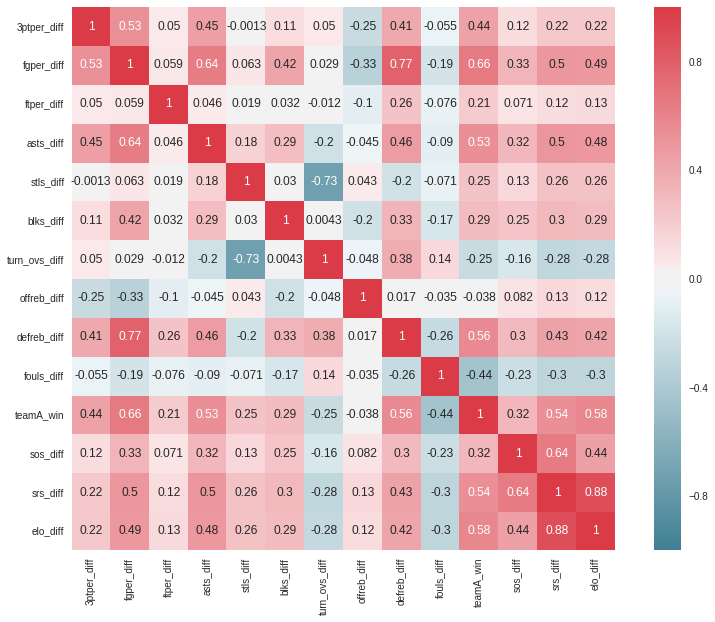

In [174]:
import seaborn as sns

cols = ['3ptper_diff', 'fgper_diff', 'ftper_diff', 'asts_diff', 'stls_diff', 'blks_diff', 
        'turn_ovs_diff', 'offreb_diff', 'defreb_diff', 'fouls_diff', 'teamA_win', 'sos_diff', 
        'srs_diff', 'elo_diff']

f, ax = plt.subplots(figsize=(14, 10))
corr = final_df[cols].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)
plt.tight_layout
plt.show()

In [175]:
all_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77550 entries, 0 to 913
Data columns (total 36 columns):
Season      77550 non-null int64
Daynum      77550 non-null int64
Wteam       77550 non-null int64
Wscore      77550 non-null int64
Lteam       77550 non-null int64
Lscore      77550 non-null int64
Wloc        77550 non-null object
Numot       77550 non-null int64
Wfgm        77550 non-null int64
Wfga        77550 non-null int64
Wfgm3       77550 non-null int64
Wfga3       77550 non-null int64
Wftm        77550 non-null int64
Wfta        77550 non-null int64
Wor         77550 non-null int64
Wdr         77550 non-null int64
Wast        77550 non-null int64
Wto         77550 non-null int64
Wstl        77550 non-null int64
Wblk        77550 non-null int64
Wpf         77550 non-null int64
Lfgm        77550 non-null int64
Lfga        77550 non-null int64
Lfgm3       77550 non-null int64
Lfga3       77550 non-null int64
Lftm        77550 non-null int64
Lfta        77550 non-null int64
L

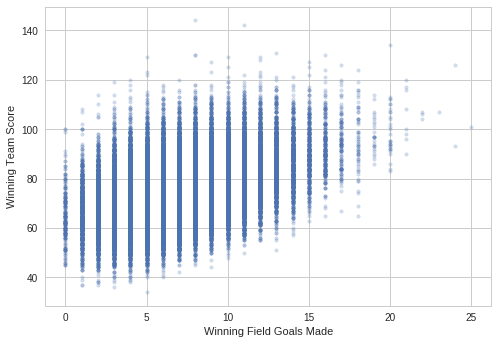

In [176]:
plt.scatter(x=all_games['Wfgm3'], y=all_games['Wscore'], marker='.', alpha=0.25)
plt.xlabel('Winning Field Goals Made')
plt.ylabel('Winning Team Score')
ax = plt.gca()
plt.show()

In [179]:
def createTrainingSet(df, year, cols):
    '''
    Takes dataframe (df) and removes the given year and tournament games. Then takes that new filtered dataframe
    and creates X matrix with selected columns (cols) and y vector from dataframe
    Make sure dataframe being fed to function has following columns: season, reg_tour, teamA_win
    '''
    
    df_train = df[(df['season'] != year) & (df['reg_tour'] != 'tour')] #remove one tournament year that will be tested
    feat_cols = cols
    
    X_train = df_train[feat_cols]
    y_train = df_train['teamA_win']

    return X_train, y_train

In [180]:
def createTestSet(df, year, cols):
    df_test = df[(df['season'] == year) & (df['reg_tour'] == 'tour')]
    feat_cols = cols
    
    X_test = df_test[feat_cols]
    y_test = df_test['teamA_win']

    return X_test, y_test

In [181]:
year = 2016  #season to test/remove from training set
cols = ['3ptper_diff', 'fgper_diff', 'ftper_diff', 'asts_diff', 'stls_diff',
                 'blks_diff', 'turn_ovs_diff', 'offreb_diff', 'defreb_diff', 'fouls_diff',
                 'sos_diff', 'srs_diff', 'elo_diff']
X_train, y_train = createTrainingSet(final_df, year, cols)
X_test, y_test = createTestSet(final_df, year, cols)

In [ ]:
X_train.sort_values(by='season', ascending=False)

In [74]:
feat_cols = ['3ptper_diff', 'fgper_diff', 'ftper_diff', 'asts_diff', 'stls_diff',
             'blks_diff', 'turn_ovs_diff', 'offreb_diff', 'defreb_diff', 'fouls_diff',
             'sos_diff', 'srs_diff', 'elo_diff']

X = final_df[feat_cols]
y = final_df['teamA_win']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.25)

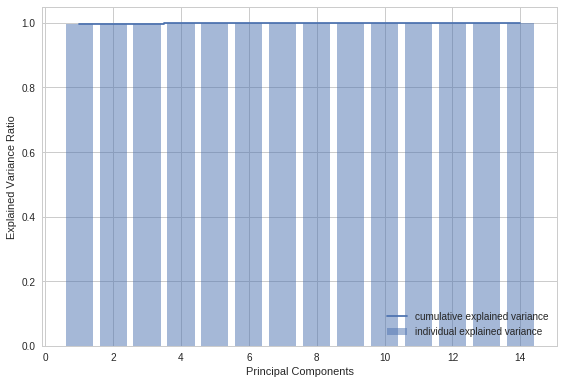

In [77]:
pca = PCA()

pca.fit(X_train)
exp_var = pca.explained_variance_ratio_
exp_var_sum = np.cumsum(exp_var)

#plot explained variance ratio
plt.bar(range(1, len(exp_var) + 1), exp_var_sum, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, len(exp_var) + 1), exp_var_sum, where='mid', label='cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [53]:
#get reduced dataset
pca_n = PCA(n_components = 7)
X_train_pca = pca_n.fit_transform(X_train)
X_test_pca = pca_n.transform(X_test)

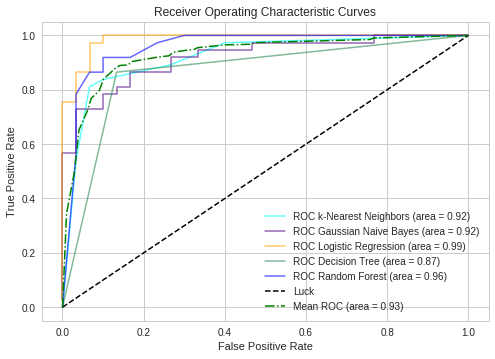

In [183]:
cv = StratifiedKFold(n_splits=10)
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
}

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'orange', 'seagreen', 'blue', 'salmon', 'darkorange'])
lw=1.5  #line width
i = 0
for (name, model), color in zip(models.items(), colors):
    probas_ = model.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color, alpha=0.6,
             label='ROC %s (area = %0.2f)' % (name, roc_auc))

    i += 1
        
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= i
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='-.',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend(loc="lower right")

plt.tight_layout
#plt.savefig('figures/ROC.png', bbox_inches='tight', dpi=300)

plt.show()

In [184]:
def prec_recal_score(model, f, l):
    cross_val_score(model, f, l, cv=10, scoring = 'accuracy')
    y_train_pred = cross_val_predict(model, f, l, cv=5)
    prec_score = precision_score(l, y_train_pred)
    recal_score = recall_score(l, y_train_pred)    
    
    cm = confusion_matrix(l, y_train_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
        
    print('Model: ', model)
    print('Precision Score: ', prec_score)
    print('Recall Score', recal_score)
    print('Specificity Score: ', TNR, '\n')
    print(classification_report(l, y_train_pred))
    print(confusion_matrix(l, y_train_pred))

In [185]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

train_acc = lr.score(X_train, y_train)
test_acc = lr.score(X_test, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)

Train accuracy:  0.953751385634
Test accuracy:  0.955223880597


In [58]:
lr = LogisticRegression()

lr.fit(X_train_pca, y_train)

train_acc = lr.score(X_train_pca, y_train)
test_acc = lr.score(X_test_pca, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)

Train accuracy:  0.91754779451
Test accuracy:  0.904298310066


In [59]:
cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')
print(np.mean(cv_scores))

0.949468692298


In [60]:
prec_recal_score(lr, X_train, y_train)

Model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Precision Score:  0.960390682841
Recall Score 0.93372276515
Specificity Score:  0.964133769951 

             precision    recall  f1-score   support

        0.0       0.94      0.96      0.95     38783
        1.0       0.96      0.93      0.95     36121

avg / total       0.95      0.95      0.95     74904

[[37392  1391]
 [ 2394 33727]]


In [61]:
nb = GaussianNB()
nb.fit(X_train, y_train)

train_acc = nb.score(X_train, y_train)
test_acc = nb.score(X_test, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)

Train accuracy:  0.91362277048
Test accuracy:  0.91036002939


In [62]:
prec_recal_score(nb, X_train, y_train)

Model:  GaussianNB(priors=None)
Precision Score:  0.922596825216
Recall Score 0.896237645691
Specificity Score:  0.929969316453 

             precision    recall  f1-score   support

        0.0       0.91      0.93      0.92     38783
        1.0       0.92      0.90      0.91     36121

avg / total       0.91      0.91      0.91     74904

[[36067  2716]
 [ 3748 32373]]


In [186]:
dtc = DecisionTreeClassifier(random_state = 42)

dtc.fit(X_train, y_train)

train_acc = dtc.score(X_train, y_train)
test_acc = dtc.score(X_test, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)

Train accuracy:  1.0
Test accuracy:  0.89552238806


In [89]:
prec_recal_score(dtc, X_train, y_train)

Model:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
Precision Score:  0.902497261159
Recall Score 0.900347494675
Specificity Score:  0.902453418767 

             precision    recall  f1-score   support

          0       0.90      0.90      0.90     35583
          1       0.90      0.90      0.90     35684

avg / total       0.90      0.90      0.90     71267

[[32112  3471]
 [ 3556 32128]]


In [187]:
pd.DataFrame({'feature': X_train.columns, 'importance': dtc.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
1,fgper_diff,0.460936
12,elo_diff,0.138390
9,fouls_diff,0.088933
6,turn_ovs_diff,0.081796
0,3ptper_diff,0.050610
8,defreb_diff,0.048220
2,ftper_diff,0.036281
7,offreb_diff,0.030191
3,asts_diff,0.017982
11,srs_diff,0.013502


In [188]:
sgd = SGDClassifier()

sgd.fit(X_train, y_train)

train_acc = sgd.score(X_train, y_train)
test_acc = sgd.score(X_test, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)

Train accuracy:  0.861829458235
Test accuracy:  0.880597014925


In [69]:
lr.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [189]:
lr = LogisticRegression()

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}


grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')

#param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
#clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
#GridSearchCV(cv=None,
##             estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
 #              dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
 #            param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})


start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
print('best params: ', grid_search.best_params_)
print('best estimator: ', grid_search.best_estimator_)

GridSearchCV took 181.20 seconds for 28 candidate parameter settings.
best params:  {'C': 10, 'solver': 'newton-cg'}
best estimator:  LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)


In [190]:
accuracy = []
lr = LogisticRegression(C=10, solver='newton-cg')
model = lr

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)
    results = model.fit(X_train, y_train)
    preds = model.predict(X_test)

    preds[preds < .5] = 0
    preds[preds >= .5] = 1
    accuracy.append(np.mean(preds == y_test))
    #accuracy.append(np.mean(predictions == Y_test))
    print('Finished iteration: ', i)
print('The accuracy is', sum(accuracy)/len(accuracy))

Finished iteration:  0
Finished iteration:  1
Finished iteration:  2
Finished iteration:  3
Finished iteration:  4
The accuracy is 0.954503447568


In [72]:
model.coef_

array([[  1.01319613e+01,   4.49508436e+01,   8.23479619e+00,
          1.22211463e-01,   6.68257188e-02,   6.24377743e-02,
         -6.02989359e-01,   3.50914422e-01,   2.19044340e-01,
         -3.04912527e-01,   6.82280157e-03,  -3.52063319e-02,
          5.28715123e-03]])

In [73]:
np.exp(model.coef_)

array([[  2.51336112e+04,   3.32585519e+19,   3.76987147e+03,
          1.12999303e+00,   1.06910914e+00,   1.06442822e+00,
          5.47173491e-01,   1.42036577e+00,   1.24488647e+00,
          7.37187856e-01,   1.00684613e+00,   9.65406202e-01,
          1.00530115e+00]])

In [74]:
model.intercept_

array([-0.57994986])

In [191]:
import plotly.plotly as py
import plotly.graph_objs as go

from sklearn import linear_model

import pylab
from scipy.optimize import curve_fit

In [192]:
y_pred = model.predict_proba(X_train)
y_pred = pd.DataFrame(y_pred[:,1])
y_pred = np.array(y_pred[0])

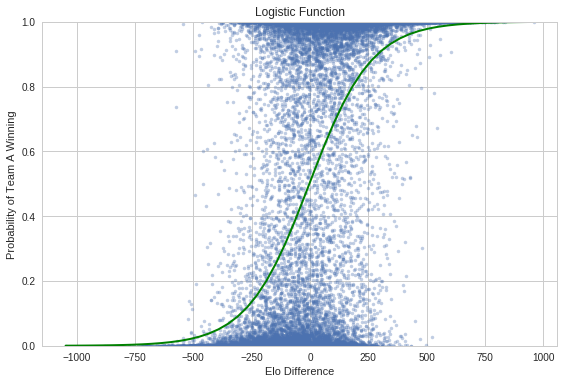

In [193]:
def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

xdata = X_train['elo_diff']
ydata = y_pred

popt, pcov = curve_fit(sigmoid, xdata, ydata)

x = np.linspace(xdata.min(), xdata.max())
y = sigmoid(x, *popt)

pylab.plot(figsize=(18, 12))
pylab.plot(xdata, ydata, '.', alpha=0.35)
pylab.plot(x, y, 'g-', linewidth=2)
pylab.ylim(0, 1)
pylab.xlabel('Elo Difference')
pylab.ylabel('Probability of Team A Winning')
pylab.title('Logistic Function')
pylab.tight_layout()
pylab.show()

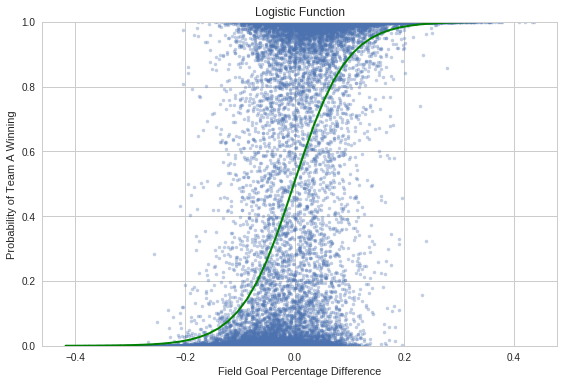

In [194]:
def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

xdata = X_train['fgper_diff']
ydata = y_pred

popt, pcov = curve_fit(sigmoid, xdata, ydata)

x = np.linspace(xdata.min(), xdata.max())
y = sigmoid(x, *popt)

pylab.plot(figsize=(18, 12))
pylab.plot(xdata, ydata, '.', alpha=0.35)
pylab.plot(x, y, 'g-', linewidth=2)
pylab.ylim(0, 1)
pylab.xlabel('Field Goal Percentage Difference')
pylab.ylabel('Probability of Team A Winning')
pylab.title('Logistic Function')
pylab.tight_layout()
pylab.show()

In [195]:
team_season_stats.head(10)

,season,Team_Id,elo,Team_Name,sos,srs
0,2003,1101,1045.25,Abilene Chr,0.00,0.00
1,2003,1102,1270.00,Air Force,1.46,1.71
2,2003,1103,1291.00,Akron,-1.43,-0.80
3,2003,1104,1413.00,Alabama,9.40,13.36
4,2003,1105,1046.00,Alabama A&M,-11.83,-16.71
5,2003,1106,1196.00,Alabama St,-10.00,-10.33
6,2003,1107,1090.00,Albany NY,-5.09,-14.87
7,2003,1108,1222.00,Alcorn St,-8.36,-12.39
8,2003,1110,1326.00,American Univ,-5.85,-1.38
9,2003,1111,1322.00,Appalachian St,-3.46,-1.92


In [196]:
Wteam_stats = team_season_stats.copy()
Wteam_stats.rename(columns={'Team_Id': 'Wteam', 'sos': 'W_sos', 'srs': 'W_srs', 'elo': 'W_elo'}, inplace=True)
Wteam_stats = Wteam_stats[['season', 'W_sos', 'W_srs', 'W_elo', 'Wteam']]
Wteam_stats.head(10)

,season,W_sos,W_srs,W_elo,Wteam
0,2003,0.00,0.00,1045.25,1101
1,2003,1.46,1.71,1270.00,1102
2,2003,-1.43,-0.80,1291.00,1103
3,2003,9.40,13.36,1413.00,1104
4,2003,-11.83,-16.71,1046.00,1105
5,2003,-10.00,-10.33,1196.00,1106
6,2003,-5.09,-14.87,1090.00,1107
7,2003,-8.36,-12.39,1222.00,1108
8,2003,-5.85,-1.38,1326.00,1110
9,2003,-3.46,-1.92,1322.00,1111


In [197]:
Lteam_stats = team_season_stats.copy()
Lteam_stats.rename(columns={'Team_Id': 'Lteam', 'sos': 'L_sos', 'srs': 'L_srs', 'elo': 'L_elo'}, inplace=True)
Lteam_stats = Lteam_stats[['season', 'L_sos', 'L_srs', 'L_elo', 'Lteam']]

In [198]:
Wschool_names = teams.copy()
Wschool_names.rename(columns={'Team_Id': 'Wteam', 'Team_Name': 'Win_school'}, inplace=True)
Wschool_names.head()

,Wteam,Win_school
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


In [199]:
Lschool_names = teams.copy()
Lschool_names.rename(columns={'Team_Id': 'Lteam', 'Team_Name': 'Lose_school'}, inplace=True)
Lschool_names.head()

,Lteam,Lose_school
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


In [200]:
season_df2 = all_games.copy()
season_df2.rename(columns={'Season': 'season'}, inplace=True)

In [201]:
#bring in school names for winning team from kaggle team data set
season_df2 = pd.merge(left=season_df2, right=Wschool_names, 
                         left_on=['Wteam'], right_on=['Wteam'], how='outer')

In [202]:
#bring in school names for losing team from kaggle team data set
season_df2 = pd.merge(left=season_df2, right=Lschool_names, 
                         left_on=['Lteam'], right_on=['Lteam'], how='outer')

In [203]:
season_df2.head()

,season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Ldr,Last,Lto,Lstl,Lblk,Lpf,reg_tour,game_id,Win_school,Lose_school
0,2003.0,10.0,1104.0,68.0,1328.0,62.0,N,0.0,27.0,58.0,...,22.0,8.0,18.0,9.0,2.0,20.0,reg,2003_1104_1328_10,Alabama,Oklahoma
1,2007.0,63.0,1104.0,70.0,1328.0,55.0,H,0.0,22.0,48.0,...,18.0,12.0,15.0,7.0,2.0,18.0,reg,2007_1104_1328_63,Alabama,Oklahoma
2,2007.0,21.0,1272.0,77.0,1328.0,65.0,N,0.0,25.0,51.0,...,22.0,8.0,21.0,3.0,5.0,29.0,reg,2007_1272_1328_21,Memphis,Oklahoma
3,2008.0,10.0,1272.0,63.0,1328.0,53.0,N,0.0,22.0,57.0,...,28.0,12.0,19.0,9.0,1.0,21.0,reg,2008_1272_1328_10,Memphis,Oklahoma
4,2017.0,47.0,1272.0,99.0,1328.0,94.0,A,1.0,33.0,58.0,...,19.0,12.0,10.0,7.0,3.0,22.0,reg,2017_1272_1328_47,Memphis,Oklahoma


In [204]:
season_df2.dropna(inplace=True)
season_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77550 entries, 0 to 77549
Data columns (total 38 columns):
season         77550 non-null float64
Daynum         77550 non-null float64
Wteam          77550 non-null float64
Wscore         77550 non-null float64
Lteam          77550 non-null float64
Lscore         77550 non-null float64
Wloc           77550 non-null object
Numot          77550 non-null float64
Wfgm           77550 non-null float64
Wfga           77550 non-null float64
Wfgm3          77550 non-null float64
Wfga3          77550 non-null float64
Wftm           77550 non-null float64
Wfta           77550 non-null float64
Wor            77550 non-null float64
Wdr            77550 non-null float64
Wast           77550 non-null float64
Wto            77550 non-null float64
Wstl           77550 non-null float64
Wblk           77550 non-null float64
Wpf            77550 non-null float64
Lfgm           77550 non-null float64
Lfga           77550 non-null float64
Lfgm3          775

In [205]:
season_df2 = pd.merge(left=season_df2, right=Wteam_stats,
                      left_on=['season', 'Wteam'], right_on=['season', 'Wteam'], how='outer')

In [206]:
season_df2.replace(np.nan, 0, inplace=True)

In [207]:
season_df2 = pd.merge(left=season_df2, right=Lteam_stats,
                      left_on=['season', 'Lteam'], right_on=['season', 'Lteam'], how='outer')

In [208]:
season_df2.replace(np.nan, 0, inplace=True)

In [209]:
season_df2.head()

,season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,reg_tour,game_id,Win_school,Lose_school,W_sos,W_srs,W_elo,L_sos,L_srs,L_elo
0,2003.0,10.0,1104.0,68.0,1328.0,62.0,N,0.0,27.0,58.0,...,reg,2003_1104_1328_10,Alabama,Oklahoma,9.40,13.36,1413.0,8.53,18.86,1626.0
1,2003.0,98.0,1400.0,67.0,1328.0,61.0,H,0.0,25.0,64.0,...,reg,2003_1400_1328_98,Texas,Oklahoma,9.27,18.91,1588.0,8.53,18.86,1626.0
2,2003.0,124.0,1400.0,76.0,1328.0,71.0,A,0.0,27.0,50.0,...,reg,2003_1400_1328_124,Texas,Oklahoma,9.27,18.91,1588.0,8.53,18.86,1626.0
3,2003.0,114.0,1281.0,67.0,1328.0,52.0,H,0.0,24.0,55.0,...,reg,2003_1281_1328_114,Missouri,Oklahoma,10.15,14.87,1516.0,8.53,18.86,1626.0
4,2003.0,70.0,1329.0,48.0,1328.0,46.0,H,0.0,19.0,49.0,...,reg,2003_1329_1328_70,Oklahoma St,Oklahoma,8.46,14.62,1472.0,8.53,18.86,1626.0


In [210]:
#df.a = df.a.astype(float)
season_df2.season = season_df2.season.astype(int)
season_df2.Daynum = season_df2.Daynum.astype(int)
season_df2.Wteam = season_df2.Wteam.astype(int)
season_df2.Wscore = season_df2.Wscore.astype(int)
season_df2.Lteam = season_df2.Lteam.astype(int)
season_df2.Lscore = season_df2.Lscore.astype(int)

In [211]:
season_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77945 entries, 0 to 77944
Data columns (total 44 columns):
season         77945 non-null int64
Daynum         77945 non-null int64
Wteam          77945 non-null int64
Wscore         77945 non-null int64
Lteam          77945 non-null int64
Lscore         77945 non-null int64
Wloc           77945 non-null object
Numot          77945 non-null float64
Wfgm           77945 non-null float64
Wfga           77945 non-null float64
Wfgm3          77945 non-null float64
Wfga3          77945 non-null float64
Wftm           77945 non-null float64
Wfta           77945 non-null float64
Wor            77945 non-null float64
Wdr            77945 non-null float64
Wast           77945 non-null float64
Wto            77945 non-null float64
Wstl           77945 non-null float64
Wblk           77945 non-null float64
Wpf            77945 non-null float64
Lfgm           77945 non-null float64
Lfga           77945 non-null float64
Lfgm3          77945 non-null 

In [212]:
def getGame_Count(team_id, season_yr):
    data_season = season_df2[(season_df2['season'] == season_yr)]  #create dataframe for just season in question
    games_won = data_season[data_season['Wteam'] == team_id]   #df of games won by season & team
    games_lost = data_season[data_season['Lteam'] == team_id]   #df of games lost by season & team
    all_games = games_won.append(games_lost)
    return all_games.season.count()

In [213]:
getGame_Count(1242, 2016)

37

In [214]:
def getTeam_Name(team_id):
    try:
        name = teams[teams['Team_Id'] == team_id].Team_Name.values[0]
    except:
        name = 'No Team Name'
    return name

In [215]:
def getTeam_ID(team_name):
    try:
        teamid = teams[teams['Team_Name'] == team_name].Team_Id.values[0]
    except:
        teamid = 'No Team Id'
    return teamid

In [216]:
getTeam_Name(1242)

'Kansas'

In [217]:
def getSeason_Data(team_id, season_yr):
    data_season = season_df2[(season_df2['season'] == season_yr)]  #create dataframe for just season in question
    games_won = data_season[data_season['Wteam'] == team_id]   #df of games won by season & team
    games_lost = data_season[data_season['Lteam'] == team_id]   #df of games lost by season & team
    all_games = games_won.append(games_lost)
    
    num_games = len(all_games.index)
    
    team_name = getTeam_Name(team_id)
    test = season_df2[(season_df2['Wteam'] == team_id) & (season_df2['season'] == season_yr)].head(1)
    
    if (team_name == 'No Team Name' or len(test) == 0):
        season_3ptper = 0    
        season_fgper = 0
        season_ftper = 0
        season_asts_pg = 0
        season_stls_pg = 0
        season_blks_pg = 0
        season_tos_pg = 0
        season_offreb_pg = 0
        season_defreb_pg = 0
        season_pf_pg = 0
        season_sos = 0
        season_srs = 0
        season_elo = 0
    else:
        total_fgm = games_won.Wfgm.sum() + games_lost.Lfgm.sum()
        total_fga = games_won.Wfga.sum() + games_lost.Lfga.sum()
        season_fgper = total_fgm / total_fga

        total_3ptm = games_won.Wfgm3.sum() + games_lost.Lfgm3.sum()
        total_3pta = games_won.Wfga3.sum() + games_lost.Lfga3.sum()
        season_3ptper = total_3ptm / total_3pta

        total_ftm = games_won.Wftm.sum() + games_lost.Lftm.sum()
        total_fta = games_won.Wfta.sum() + games_lost.Lfta.sum()
        season_ftper = total_ftm / total_fta

        total_offreb = games_won.Wor.sum() + games_lost.Lor.sum()
        season_offreb_pg = total_offreb / num_games

        total_defreb = games_won.Wdr.sum() + games_lost.Ldr.sum()
        season_defreb_pg = total_defreb / num_games

        total_asts = games_won.Wast.sum() + games_lost.Last.sum()
        season_asts_pg = total_asts / num_games

        total_tos = games_won.Wto.sum() + games_lost.Lto.sum()
        season_tos_pg = total_tos / num_games

        total_blks = games_won.Wblk.sum() + games_lost.Lblk.sum()
        season_blks_pg = total_blks / num_games

        total_stls = games_won.Wstl.sum() + games_lost.Lstl.sum()
        season_stls_pg = total_stls / num_games

        total_pfs = games_won.Wpf.sum() + games_lost.Lpf.sum()
        season_pf_pg = total_pfs / num_games
        
        season_sos = max(games_won.W_sos.mean(), games_lost.L_sos.mean())
        
        season_srs = max(games_won.W_srs.mean(), games_lost.L_srs.mean())
        
        season_elo = max(games_won.W_elo.mean(), games_lost.L_elo.mean())
        
    return [season_3ptper, season_fgper, season_ftper, season_asts_pg, season_stls_pg,
            season_blks_pg, season_tos_pg, season_offreb_pg, season_defreb_pg, season_pf_pg,
            season_sos, season_srs, season_elo]  

In [218]:
def getSeason_Record(team_id, season_yr):
    data_season = season_df2[(season_df2['season'] == season_yr)]  #create dataframe for just season in question
    games_won = data_season[data_season['Wteam'] == team_id]   #df of games won by season & team
    games_lost = data_season[data_season['Lteam'] == team_id]   #df of games lost by season & team
    all_games = games_won.append(games_lost)
    
    num_games = len(all_games.index)
    
    team_name = getTeam_Name(team_id)
    test = season_df2[(season_df2['Wteam'] == team_id) & (season_df2['season'] == season_yr)].head(1)
    
    wins = len(games_won.index)
    losses = len(games_lost.index)
       
    return 'Season ' + str(season_yr) + ' record: ' + str(wins) + ' - ' + str(losses)

In [219]:
def getSeason_Games(team_id, season_yr):
    data_season = season_df2[(season_df2['season'] == season_yr)]  #create dataframe for just season in question
    games_won = data_season[data_season['Wteam'] == team_id]   #df of games won by season & team
    games_lost = data_season[data_season['Lteam'] == team_id]   #df of games lost by season & team
    all_games = games_won.append(games_lost)
    
    num_games = len(all_games.index)
    
    team_name = getTeam_Name(team_id)
    test = season_df2[(season_df2['Wteam'] == team_id) & (season_df2['season'] == season_yr)].head(1)
    
    wins = len(games_won.index)
    losses = len(games_lost.index)
       
    return all_games.sort_values(by=['Daynum'])

In [220]:
team = 'Kentucky'

print(team)
print(getSeason_Record(getTeam_ID(team), 2015))
getSeason_Games(getTeam_ID(team), 2015)

Kentucky
Season 2015 record: 38 - 1


,season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,reg_tour,game_id,Win_school,Lose_school,W_sos,W_srs,W_elo,L_sos,L_srs,L_elo
55954,2015,11,1246,85,1213,45,H,0.0,34.0,70.0,...,reg,2015_1246_1213_11,Kentucky,Grand Canyon,8.67,28.72,1892.0,-5.45,-6.62,1214.0
4875,2015,13,1246,71,1138,52,H,0.0,25.0,61.0,...,reg,2015_1246_1138_13,Kentucky,Buffalo,8.67,28.72,1892.0,1.60,7.93,1516.0
17634,2015,15,1246,72,1242,40,N,0.0,25.0,58.0,...,reg,2015_1246_1242_15,Kentucky,Kansas,8.67,28.72,1892.0,12.13,18.47,1680.0
66724,2015,18,1246,89,1131,65,H,0.0,34.0,59.0,...,reg,2015_1246_1131_18,Kentucky,Boston Univ,8.67,28.72,1892.0,-3.12,-5.63,1226.0
40004,2015,20,1246,86,1286,28,H,0.0,29.0,67.0,...,reg,2015_1246_1286_20,Kentucky,Montana St,8.67,28.72,1892.0,-3.50,-12.91,1024.0
69588,2015,22,1246,92,1426,44,H,0.0,30.0,53.0,...,reg,2015_1246_1426_22,Kentucky,UT Arlington,8.67,28.72,1892.0,-2.76,-3.59,1200.0
66718,2015,27,1246,58,1344,38,H,0.0,24.0,53.0,...,reg,2015_1246_1344_27,Kentucky,Providence,8.67,28.72,1892.0,9.50,13.71,1581.0
8333,2015,32,1246,63,1400,51,H,0.0,21.0,56.0,...,reg,2015_1246_1400_32,Kentucky,Texas,8.67,28.72,1892.0,9.07,16.16,1524.0
41451,2015,34,1246,82,1184,49,H,0.0,33.0,58.0,...,reg,2015_1246_1184_34,Kentucky,E Kentucky,8.67,28.72,1892.0,-4.16,-0.03,1330.0
71933,2015,37,1246,56,1162,46,H,0.0,22.0,60.0,...,reg,2015_1246_1162_37,Kentucky,Columbia,8.67,28.72,1892.0,-1.49,-0.38,1215.0


In [221]:
getTeam_ID('S Dakota St')

1355

In [222]:
team = 'Stony Brook'
getSeason_Data(getTeam_ID(team), 2016)

[0.37169811320754714,
 0.46800433839479394,
 0.6722972972972973,
 16.096774193548388,
 5.903225806451613,
 4.548387096774194,
 11.741935483870968,
 12.258064516129032,
 26.322580645161292,
 16.161290322580644,
 -5.28,
 3.75,
 1498.0]

In [223]:
team = 'Kentucky'
getSeason_Data(getTeam_ID(team), 2016)

[0.3663663663663664,
 0.4783620288506282,
 0.6900369003690037,
 14.222222222222221,
 5.722222222222222,
 5.805555555555555,
 11.11111111111111,
 12.722222222222221,
 25.88888888888889,
 20.47222222222222,
 8.840000000000002,
 20.230000000000004,
 1675.0]

In [224]:
def Team_Compare(team_A, team_B, year):
    team_1 = getSeason_Data(team_A, year)
    team_2 = getSeason_Data(team_B, year)
    diff = [a - b for a, b in zip(team_1, team_2)]
    return diff

In [225]:
Team_Compare(1242, 1390, 2010)

[0.05078563411896747,
 0.05559989618490058,
 0.035519196017154586,
 3.822916666666668,
 2.9861111111111107,
 4.756944444444445,
 0.9305555555555554,
 2.46875,
 4.222222222222221,
 0.7465277777777786,
 1.75,
 18.97,
 475.0]

In [226]:
team_list = teams['Team_Name'].tolist()

def MakeSeason_Dict(year):
    season_dict = c.defaultdict(list)
    for team in team_list:
        team_id = teams[teams['Team_Name'] == team].values[0][0]
        team_vector = Season_Data(team_id, year)
        season_dict[team_id] = team_vector
    return season_dict

In [228]:
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(C=10, solver='newton-cg'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Bernoulli Naive Bayes': BernoulliNB()
}
def predictOutcome_avg(team1, team2, year, X, y):
    diff = Team_Compare(getTeam_ID(team1), getTeam_ID(team2), year)
    outcomes = []
    scores = []
    for k, v in models.items():
        v.fit(X, y)
        scores.append(v.score(X_train, y_train))
        outcomes.append(v.predict_proba(diff)[0,1])
        #outcomes.append((k + ': ' + 'Probability that ' + team1_name + ' beats ' + team2_name + ': ', 
                         #v.predict_proba(diff)[0,1]))
        #outcomes.append(outcome)
    result = (sum(outcomes) / len(outcomes)) * 100
    #stmt = 'Average probability that ' + team1_name + ' beats ' + team2_name + ': ' + result
    return result
    #return model.predict(diff)

In [229]:
def predictOutcome(team1, team2, year, X, y):
    lr = LogisticRegression(C=10, solver='newton-cg')
    model = lr
    diff = Team_Compare(getTeam_ID(team1), getTeam_ID(team2), year)
    model.fit(X, y)
    return lr.predict_proba(diff)[0,1]

In [230]:
getSeason_Data(1463, 2016)

[0.3603960396039604,
 0.4658881376767056,
 0.672566371681416,
 14.96551724137931,
 5.482758620689655,
 4.517241379310345,
 13.344827586206897,
 13.517241379310345,
 26.689655172413794,
 17.862068965517242,
 -1.03,
 9.080000000000004,
 1516.0]

In [231]:
getTeam_ID('Stephen Austin')

'No Team Id'

In [232]:
def findTeam_Like(l):
    potential_teams = []
    for t in teams.Team_Name:
        if t.startswith(l):
            potential_teams.append(t)
    return potential_teams

In [240]:
findTeam_Like('J')

['Jackson St', 'Jacksonville', 'Jacksonville St', 'James Madison']

In [148]:
final_df_copy = final_df.copy()

In [149]:
final_df_copy.head()

,team_A,team_B,daynum,season,game_id,team_A_loc,3ptper_diff,fgper_diff,ftper_diff,asts_diff,...,blks_diff,turn_ovs_diff,offreb_diff,defreb_diff,fouls_diff,teamA_win,sos_diff,srs_diff,elo_diff,reg_tour
0,1365,1211,125,2004,2004_1211_1365_125,H,0.145714,0.008333,0.085470,4,...,-3,2,-2,3,9,0,-0.71,-18.14,-395.00,reg
1,1429,1102,72,2016,2016_1429_1102_72,H,-0.130769,0.095865,0.245098,1,...,4,-1,0,9,-4,1,1.40,8.19,107.00,reg
2,1440,1151,108,2016,2016_1151_1440_108,A,-0.128146,-0.213867,0.028986,-10,...,-3,2,-1,-13,-6,0,0.31,-16.20,-487.00,reg
3,1340,1431,26,2004,2004_1431_1340_26,A,0.000000,0.007219,-0.205882,-1,...,1,15,3,8,5,0,0.00,0.00,-369.00,reg
4,1154,1189,65,2007,2007_1154_1189_65,A,0.063492,0.135025,-0.112500,4,...,-2,2,-3,5,-3,1,0.67,-3.61,-44.25,reg


In [239]:
year = 2016  #season to remove from training set, season year is year of tournament

cols_all = ['3ptper_diff', 'fgper_diff', 'ftper_diff', 'asts_diff', 'stls_diff',
                 'blks_diff', 'turn_ovs_diff', 'offreb_diff', 'defreb_diff', 'fouls_diff',
                 'sos_diff', 'srs_diff', 'elo_diff']

#columns that have >= 0.5 correlation with teamA_win in correlation matrix
cols_50 = ['fgper_diff', 'asts_diff', 'defreb_diff', 'elo_diff', 'teamA_win', 'season', 'reg_tour']

cols = cols_all

df_model = final_df[cols]

X_train, y_train = createTrainingSet(final_df, year, cols)

team1_name = 'New Mexico'
team2_name = 'Kansas'
answer = str(round(predictOutcome_avg(team1_name, team2_name, year, X_train, y_train), 2))

print('Probability that ' + team1_name + ' beats ' + team2_name + ': ' + answer + '% (season data: ' + str(year) + ')')

Probability that New Mexico beats Kansas: 0.04% (season data: 2016)


In [238]:
year = 2015 #season to remove from training set 
cols_all = ['3ptper_diff', 'fgper_diff', 'ftper_diff', 'asts_diff', 'stls_diff',
                 'blks_diff', 'turn_ovs_diff', 'offreb_diff', 'defreb_diff', 'fouls_diff',
                 'sos_diff' , 'srs_diff', 'elo_diff']

cols_50 = ['fgper_diff', 'asts_diff', 'defreb_diff', 'elo_diff', 'srs_diff']

cols = cols_all

X_train, y_train = createTrainingSet(final_df, year, cols)

team1_name = 'Duke'
team2_name = "Gonzaga"

result = round(predictOutcome(team1_name, team2_name, year, X_train, y_train) * 100, 2)

answer = result
answer2 = (100 - result)

if answer > answer2:
    print('Probability that ' + team1_name + ' beats ' + team2_name + ': ' + 
          str(answer) + '% (season data: ' + str(year) + ')')
else:
    print('Probability that ' + team2_name + ' beats ' + team1_name + ': ' + 
          str(answer2) + '% (season data: ' + str(year) + ')')

Probability that Gonzaga beats Duke: 60.66% (season data: 2015)


In [ ]:
sub = submission.head(10)

In [ ]:
def createPrediction():
    game_id = []
    outcome_prob = []
    sub_df = pd.DataFrame()
    
    for index, row in submission.iterrows():
        id_row = row['Id']
        year = int(id_row[0:4])
        team1_id = int(id_row[5:9])
        team2_id = int(id_row[10:14])

        pred = predictOutcome(team1_id, team2_id, year, X_train, y_train)

        game_id.append(id_row)
        outcome_prob.append(pred[0,0])
    sub_dict = dict(zip(game_id, outcome_prob))

    outfile = open('2016_submission.csv', 'w')
    for key, value in sorted(sub_dict.items()):
        outfile.write( str(key) + ', ' + str(value) + '\n')

In [ ]:
#createPrediction()